# Bankside Capital Quant Assessment
*by Teoh Sean Keat*

## Strategy Overview

In this project, stock data from 2013-01-01 to 2023-12-31 for the "Magnificent 7" is downloaded from Yahoo Finance.
A Double Bollinger Bands Strategy is then implemented to generate buy and sell signals.
Thereafter, backtesting is performed with an initial capital of $10 000. Every time a buy or sell signal is generated and relevant criteria is met, one share of the relevant stock will be bought or sold accordingly.
Eventually, at the end of the backtesting period, existing positions are liquidated.

The strategy is then evaluated on the following performance metrics:
• Total Return
• Annual Return
• Annual Volatlity
• Sharpe Rato
• Sortino Rato
• Maximum Drawdown

### Importing Libraries

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

### Extracting Historical Price Data

In [3]:
#List of tickers
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']

#Downloads and accesses data based on start and end date
start_date = datetime(2013, 1, 1)
end_date = datetime(2023, 12, 31)
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

msft_data = data['MSFT']
aapl_data = data['AAPL']
nvda_data = data['NVDA']
amzn_data = data['AMZN']
goog_data = data['GOOG']
meta_data = data['META']
tsla_data = data['TSLA']

[*********************100%%**********************]  7 of 7 completed


In [4]:
rows, columns = data.shape
rows, columns

(2768, 42)

In [5]:
#Inspect data to check for anomalies or missing values
print(data.head())

#Check for missing values
print(data.isna().sum())

#Check for duplicate rows
print(data.duplicated().sum())

# Check for negative values in price columns
print((msft_data['Close'] < 0).sum(), (aapl_data['Close'] < 0).sum(), (nvda_data['Close'] < 0).sum(), \
     (amzn_data['Close'] < 0).sum(), (goog_data['Close'] < 0).sum(), (meta_data['Close'] < 0).sum(), \
     (tsla_data['Close'] < 0).sum())

Ticker         AMZN                                                     TSLA  \
Price          Open     High      Low    Close Adj Close    Volume      Open   
Date                                                                           
2013-01-02  12.8040  12.9050  12.6630  12.8655   12.8655  65420000  2.333333   
2013-01-03  12.8635  13.0440  12.8185  12.9240   12.9240  55018000  2.345333   
2013-01-04  12.8790  12.9900  12.8325  12.9575   12.9575  37484000  2.320000   
2013-01-07  13.1485  13.4865  13.1335  13.4230   13.4230  98200000  2.320000   
2013-01-08  13.3535  13.4490  13.1785  13.3190   13.3190  60214000  2.300000   

Ticker                                    ...     NVDA                     \
Price           High       Low     Close  ...      Low    Close Adj Close   
Date                                      ...                               
2013-01-02  2.363333  2.314000  2.357333  ...  0.31275  0.31800  0.293560   
2013-01-03  2.363333  2.316667  2.318000  ...  0.31

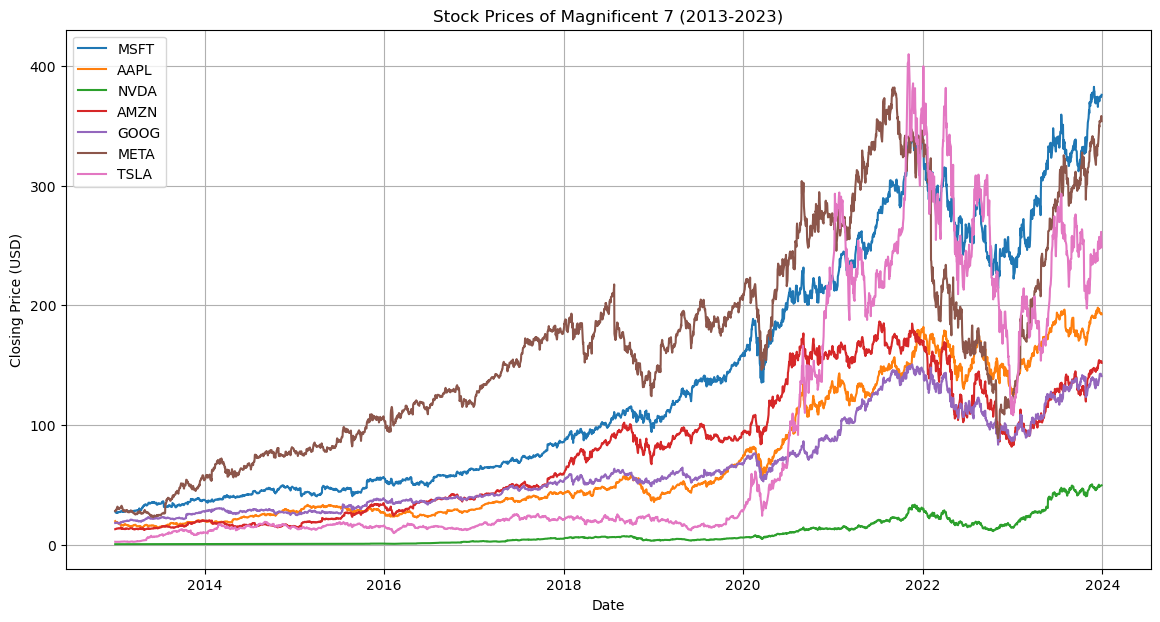

In [6]:
plt.figure(figsize=(14, 7))

# Plot the closing prices for each ticker
for ticker in tickers:
    plt.plot(data[ticker]['Close'], label=ticker)

# Add title and labels
plt.title('Stock Prices of Magnificent 7 (2013-2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Implementing Double Bollinger Bands Strategy

In [7]:
def bollinger_bands(df, sma=20, inner_std=1, outer_std=2):
    """
    Function parameters:
    df: pd.DataFrame consisting of the individual ticker's price action from 2013-01-01 to 2023-12-31
    sma: period over which the Simple Moving Average is calculated over
    inner_std: standard deviation above and below SMA for the inner Bollinger Band
    outer_std: standard deviation above and below SMA for the outer Bollinger Band
    
    Returns:
    pd.DataFrame: df with Bollinger Bands and buy and sell signals
    """
    df = df.copy()
    
    df.loc[:, 'SMA'] = df['Close'].rolling(window=sma).mean()
    df.loc[:, 'STD'] = df['Close'].rolling(window=sma).std()
    
    df.loc[:, 'Upper_1'] = df['SMA'] + inner_std * df['STD']
    df.loc[:, 'Upper_2'] = df['SMA'] + outer_std * df['STD']
    df.loc[:, 'Lower_1'] = df['SMA'] - inner_std * df['STD']
    df.loc[:, 'Lower_2'] = df['SMA'] - outer_std * df['STD']
    
    df.loc[:, 'Buy_Signal'] = np.where((df['Close'] <= df['Upper_2']) & (df['Close'] > df['Upper_1']), 1, 0)
    df.loc[:, 'Sell_Signal'] = np.where((df['Close'] >= df['Lower_2']) & (df['Close'] < df['Lower_1']), -1, 0)
    df.loc[:, 'Signal'] = df['Buy_Signal'] + df['Sell_Signal']  

    return df

In [8]:
#Visualizing the data
tsla_bands = bollinger_bands(tsla_data, sma=20, inner_std=1, outer_std=2)
tsla_bands

Price,Open,High,Low,Close,Adj Close,Volume,SMA,STD,Upper_1,Upper_2,Lower_1,Lower_2,Buy_Signal,Sell_Signal,Signal
Date,,,,,,,,,,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,244.503500,6.849882,251.353381,258.203263,237.653618,230.803736,1,0,1
2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,245.529999,7.056294,252.586293,259.642586,238.473705,231.417411,1,0,1
2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,246.265999,7.903738,254.169737,262.073476,238.362260,230.458522,1,0,1


In [9]:
#Visualizes the graph of the price with Bollinger Bands
def plot_bollinger_bands(df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['SMA'], label='SMA')
    plt.plot(df['Upper_1'], label='Upper Band 1', linestyle='--', color='green')
    plt.plot(df['Upper_2'], label='Upper Band 2', linestyle='--', color='red')
    plt.plot(df['Lower_1'], label='Lower Band 1', linestyle='--', color='green')
    plt.plot(df['Lower_2'], label='Lower Band 2', linestyle='--', color='red')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Double Bollinger Bands for {}'.format(ticker))
    plt.legend()
    plt.grid(True)
    plt.show()

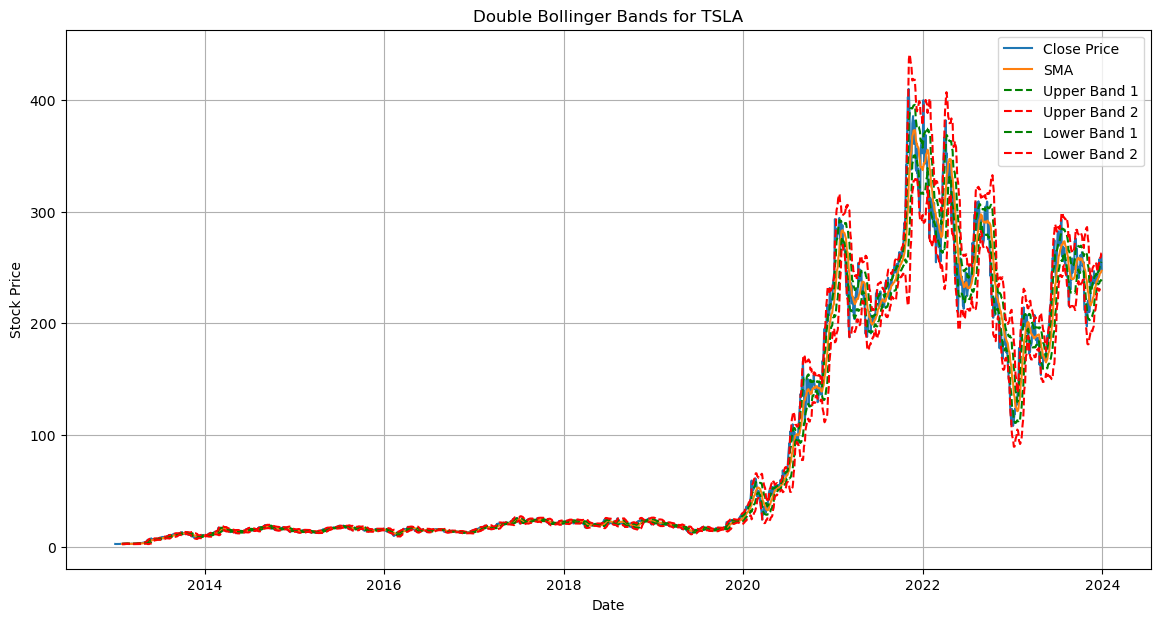

In [10]:
plot_bollinger_bands(tsla_bands, "TSLA")

### Backtesting Loop

In [16]:
#initialize variables
capital = 10000
total_profit = 0

results_list = []
portfolio = {ticker:{'Position':0, 'Buys':0, 'Sells':0, 'Profit':0} for ticker in tickers}
ticker_bands = {ticker: bollinger_bands(data[ticker], sma=20, inner_std=1, outer_std=2) for ticker in tickers}

ticker_bands

{'MSFT': Price             Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2013-01-02   27.250000   27.730000   27.150000   27.620001   22.492279   
 2013-01-03   27.629999   27.650000   27.160000   27.250000   22.190971   
 2013-01-04   27.270000   27.340000   26.730000   26.740000   21.775658   
 2013-01-07   26.770000   26.879999   26.639999   26.690001   21.734930   
 2013-01-08   26.750000   26.790001   26.459999   26.549999   21.620928   
 ...                ...         ...         ...         ...         ...   
 2023-12-22  373.679993  375.179993  372.709991  374.579987  373.215424   
 2023-12-26  375.000000  376.940002  373.500000  374.660004  373.295135   
 2023-12-27  373.690002  375.059998  372.809998  374.070007  372.707275   
 2023-12-28  375.369995  376.459991  374.160004  375.279999  373.912842   
 2023-12-29  376.000000  377.160004  373.480011  376.040009  374.670074   
 
 Price         

In [17]:
returns_df = pd.DataFrame(index=ticker_bands[tickers[0]].index)
returns_df['Value'] = 0.0  # Initialize with 0.0 instead of NaN
returns_df

,Value
Date,
2013-01-02,0.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-07,0.0
2013-01-08,0.0
...,...
2023-12-22,0.0
2023-12-26,0.0
2023-12-27,0.0


In [18]:
for i in range(rows):
    total_positions_value = 0
    for ticker in tickers:
        row = ticker_bands[ticker].iloc[i]
        # Buy Signal
        if row['Signal'] == 1 and capital >= row['Close']:
            portfolio[ticker]['Position'] += 1
            portfolio[ticker]['Buys'] += 1
            portfolio[ticker]['Profit'] -= row['Close']
            capital -= row['Close']
        
        # Sell Signal
        elif row['Signal'] == -1 and portfolio[ticker]['Position'] > 0:
            portfolio[ticker]['Position'] -= 1
            portfolio[ticker]['Sells'] += 1
            portfolio[ticker]['Profit'] += row['Close']
            capital += row['Close']
    
    for ticker in tickers:
        if portfolio[ticker]['Position'] > 0:
            last_row = ticker_bands[ticker].iloc[i]
            total_positions_value += last_row['Close'] * portfolio[ticker]['Position'] 
    # Update returns_df with total capital and positions value
    returns_df.loc[returns_df.index[i], 'Value'] = capital + total_positions_value

for ticker in tickers:
    if portfolio[ticker]['Position'] > 0:
        portfolio[ticker]['Sells'] += portfolio[ticker]['Position']
        last_row = ticker_bands[ticker].iloc[rows-1]
        portfolio[ticker]['Profit'] += last_row['Close'] * portfolio[ticker]['Position']
        capital += last_row['Close'] * portfolio[ticker]['Position']
        portfolio[ticker]['Position'] = 0

returns_df.loc[returns_df.index[rows-1], 'Value'] = capital
portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')

In [19]:
portfolio_df

,Position,Buys,Sells,Profit
MSFT,0,434,434,31451.030615
AAPL,0,441,441,4599.719836
NVDA,0,646,646,10913.456833
AMZN,0,375,375,5259.788606
GOOG,0,408,408,1420.259659
META,0,354,354,17298.249786
TSLA,0,421,421,2900.363365


In [20]:
returns_df

,Value
Date,
2013-01-02,10000.000000
2013-01-03,10000.000000
2013-01-04,10000.000000
2013-01-07,10000.000000
2013-01-08,10000.000000
...,...
2023-12-22,83617.722471
2023-12-26,83775.209539
2023-12-27,83849.123266


### Performance Metrics for Evaluation

#### Total Return

In [21]:
initial_capital = 10000
final_value = initial_capital + portfolio_df['Profit'].sum()
total_return = (final_value - initial_capital) / initial_capital
total_return

7.384286869943142

#### Annual Return

In [22]:
num_years = 10
annual_return = (final_value / initial_capital) ** (1 / num_years) - 1
annual_return

0.23693424397170038

#### Annual Volatility

In [23]:
# Step 1: Calculate Daily Returns
returns_df['Daily_Returns'] = returns_df['Value'].pct_change()

# Step 2: Calculate Daily Volatility (Standard Deviation of Daily Returns)
daily_volatility = returns_df['Daily_Returns'].std()

# Step 3: Annualize the Daily Volatility
# Assuming 252 trading days in a year
annual_volatility = daily_volatility * np.sqrt(252)

daily_volatility, annual_volatility


(0.01415818941631394, 0.2247542892630805)

#### Sharpe Ratio

In [24]:
#Assuming a 2% annual risk-free rate and 252 trading days in a year
annual_risk_free_rate = 0.02
daily_risk_free_rate = annual_risk_free_rate / 252

#Calculate Daily Excess Returns
returns_df['Excess_Returns'] = returns_df['Daily_Returns'] - daily_risk_free_rate

#Calculate Average Daily Excess Return
average_excess_return = returns_df['Excess_Returns'].mean()

#Calculate Daily Volatility of Excess Returns
daily_volatility_excess = returns_df['Excess_Returns'].std()

#Calculate Sharpe Ratio
sharpe_ratio = average_excess_return / daily_volatility_excess

# Annualize the Sharpe Ratio (assuming 252 trading days in a year)
annual_sharpe_ratio = sharpe_ratio * np.sqrt(252)

sharpe_ratio, annual_sharpe_ratio

(0.055795014992870255, 0.8857184044095299)

#### Sortino Ratio

In [25]:
#Taking Minimum Acceptable Risk mar=0
mar = 0

# Calculate Downside Deviation
# Only consider returns below MAR (negative returns relative to MAR)
returns_df['Downside_Returns'] = np.where(returns_df['Daily_Returns'] < mar, returns_df['Daily_Returns'] - mar, 0)
downside_deviation = np.sqrt((returns_df['Downside_Returns'] ** 2).mean())

# Calculate Average Daily Return
average_daily_return = returns_df['Daily_Returns'].mean()

# Step 5: Calculate Sortino Ratio
sortino_ratio = (average_daily_return - mar) / downside_deviation

# Annualize the Sortino Ratio (assuming 252 trading days in a year)
annual_sortino_ratio = sortino_ratio * np.sqrt(252)

sortino_ratio, annual_sortino_ratio


(0.08705392252856727, 1.381938177979633)

#### Maximum Drawdown

In [26]:
#Finds the highest peak
returns_df['Cumulative_Value'] = returns_df['Value'].cummax()

# Calculate the Drawdown
returns_df['Drawdown'] = (returns_df['Value'] - returns_df['Cumulative_Value']) / returns_df['Cumulative_Value']

# Calculate Maximum Drawdown
max_drawdown = returns_df['Drawdown'].min()
""
# Convert to percentage
max_drawdown_percentage = max_drawdown * 100

max_drawdown_percentage


-37.11314303916626